# Intro to the API and Plotting

In this tutorial you will learn how to plot data from the ONC database. To do this, we will:

- Define parameters.

- Request data from the database.

- Load the data into a DataFrame. You can think of a Data Frame as a highly organized and feature-rich table where each column represents a specific parameter, and each row represents an observation.

- Plot data from the DataFrame.

There is some basic terminology used throughout this and other notebooks. For information on the locations, devices, and properties you will need to interact with this tutorial, please see the notebook Glossary.

Key words: inputs/parameters, function, library, API, DataFrame, 

Text and code blocks

Throughout this notebook you will see text blocks (like this one) and code blocks (like the one right below). Code blocks contain Python commands that you can run by clicking the little blue play button at the top of each code block (appears when you hover your cursor over the block). 

You will also see some green text following the character "#". These lines of green text are comments about the code (to help you understand it), and are ignored by Python.

In [1]:
print ("Hello world!") # This is a simple Python command to print the words "Hello world!"

Hello world!


## 1. Set up programming environment

Before we jump in, we need to execute the code which below installs the ONC, pandas, and matplotlib libraries. These libraries contain external code that add extra features to Python. When we install a library, the code is placed on to your system where it can be found and used by Python.

In [2]:
!pip install onc        # Installs the ONC Python client library to access Ocean Networks Canada data via their API
!pip install pandas     # Installs pandas, a powerful library for data manipulation and analysis using DataFrames
!pip install matplotlib # Installs matplotlib, a plotting library for creating static, animated, and interactive visualizations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 15.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Moving forward in this notebook, you’ll see several lines like the following: "import ______ from ______".

This code imports the libraries that we installed in the previous step. When we import a library, it loads the installed code into our program so we can use its code.

You'll see us the libraries above for tasks like connecting to online data sources (ONC's client library), helping with data analysis (Pandas) or with making plots (Matplotlib).

## 2. Define parameters

Now that our basic environment is set up, we must define what it is we want to plot. That means choosing a locationCode, deviceCategoryCode, and time frame, just like we did with the OpenAPI.

These selections are called parameters, and they will form the overall query that we ask the API. Recall that an API is like a server in a restaurant- you tell them what you want, they tell the kitchen, and then they deliver your food from the kitchen to you when it's ready. 

Thus, we define our parameters according to what we are interested in. 

> Define your parameters in the following block of code (lines 3-6).

Initially, we will look at CTD data from the Folger Deep (FGPD) platform for 10 months in 2025. Later, you will replace these parameters to access and plot different data.

In [3]:
# INTERACTIVE: Modify the parameter values to the right of the semicolons. Use quotes. Reference the comments (in green) for default values.
params = {
    "locationCode": "FGPD",                  # "FGPD" is the location code name for ONC's Folger Deep platform
    "deviceCategoryCode": "CTD",             # "CTD" is the device category code for a Conductivity-Temperature-Depth instrument
    "dateFrom": "2025-01-01T00:00:00.000Z",  # "2025-01-01T00:00:00.000Z" is the starting date for the data you want to plot
    "dateTo": "2025-11-01T20:00:00.000Z"     # "2025-11-01T20:00:00.000Z" is the ending date for the data you want to plot
}

# STUDENT VERSION:
# params = {
#     "locationCode": "LOCATION CODE",            # "FGPD" is the location code name for ONC's Folger Deep platform
#     "deviceCategoryCode": "DEVICE CAT CODE",    # "CTD" is the device category code for a Conductivity-Temperature-Depth instrument
#     "dateFrom": "START DATE (ISO 8601 UTC)",    # "2025-01-01T00:00:00.000Z" is the starting date for the data you want to plot
#     "dateTo": "END DATE (ISO 8601 UTC)"         # "2025-11-01T20:00:00.000Z" is the ending date for the data you want to plot
# }

Note this is UTC time NOT Pacific Standard Time.

Next, the program checks if your requested time range is over 24 hours. Since the API limits responses to 100,000 lines (about 1.5 days at 1 observation per second), this code uses subsampling for longer requests by setting the resample period parameter based on the duration.

In [4]:
from datetime import datetime # Import library that recognizes your defined times as real dates in time

# Convert string inputs defined in the params above to datetime objects
start_time = datetime.fromisoformat(params['dateFrom'].replace("Z", "+00:00"))
end_time = datetime.fromisoformat(params['dateTo'].replace("Z", "+00:00"))

# Calculate the duration in hours (there are 3600 seconds in an hour)
duration_hours = (end_time - start_time).total_seconds() / 3600

# Check length of time series to request. Resample the data based on length of requested data
if duration_hours > 2190: # If greater than 3 months
    resample = 1800
elif duration_hours > 24: # If greater than 24 hours
    resample = 900
else:
    resample = None

# Set resample paramters if necessary
if resample:
    params["metadata"] = "minimum"
    params["qualityControl"] = "clean"
    params["resamplePeriod"] = resample
    params["resampleType"] = "avg"

Below are the final parameters that you will use to request data in the next step. The command print() shows all the parameters defined above as  name: value pairs— that is, the name of the parameter followed by a semi colon, followed by the value it represents. You can see them all listed in the box below.

In [5]:
print(params) # Preview the parameters

{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'dateFrom': '2025-01-01T00:00:00.000Z', 'dateTo': '2025-11-01T20:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}


## 3. Request data

### 3.1 Set up API

Before you can actually request data from the ONC API, you need to import the onc library and connect using your token. 

The library contains special functions- small, reusable blocks of code that perform specific tasks- like getScalardata(), which we use below. 

Your token lets the API know who you are and gives you permission to access the data. You can find your token by logging into https://data.oceannetworks.ca/, viewing your profile, and clicking the Web Services API tab.

<img src="onc_token.png" width="" align="" />

> Enter your token below on line 4.

In [13]:
import onc # ONC client library
from onc import ONC 

import os # remove line for student version
my_onc = ONC(token=os.environ['GRACE_TOKEN']) # INTERACTIVE: Enter your token here (in quotes).

# STUDENT VERSION: my_onc = ONC(token="YOUR TOKEN HERE") # INTERACTIVE: Enter your token here (in quotes).

Students should retrieve their own tokens now.

### 3.2 Make request

Next, we request data via the API by using your parameters with the getScalardata() function, which returns raw scalar data. The following block handles any errors that might arise from trying to run this function.

> Enter function call below on line 4.

In [14]:
from requests.exceptions import HTTPError # Import library to handle errors

try:
    api_response = my_onc.getScalardata(params) # INTERACTIVE: Make the getScalardata request. 
    # STUDENT VERSION: my_onc."ENTER FUNCTION HERE"(params) # INTERACTIVE: Make the getScalardata request.

except HTTPError as e: # Handle any issues with request and stop program
    print(f"Read the error description(s) below and adjust your input parameters accordingly.")
    print(e)
    raise SystemExit

The API will then send back a response according to your parameters. 

Below is a preview of the main sections in the API response. The sensorData section is especially important because it contains one entry for each property, where both the data and metadata for that property are stored.

In [15]:
import json # Import the json library for formatting the json response -- makes it easier for humans to read
sections = {key: str(type(value)) for key, value in api_response.items()} # Isolate the section titles in the response
print(json.dumps(sections, indent=2)) # Preview the sections

{
  "citations": "<class 'list'>",
  "messages": "<class 'list'>",
  "next": "<class 'NoneType'>",
  "parameters": "<class 'dict'>",
  "qaqcFlagInfo": "<class 'dict'>",
  "queryUrl": "<class 'str'>",
  "sensorData": "<class 'list'>"
}


## 4. Preview the properties in the API response

Let's look closer at the sensorData section of the API response by converting it into a Data Frame using the Pandas library. 

This will help you visualize the properties available from your chosen device and location.

> Enter a section of the API response to preview (line 2). Before moving on to step 5, enter 'sensorData' as your section.

In [16]:
import pandas as pd # import the library to make data frames and datetime objects; we're referring to this as "pd"
sensorData_df = pd.DataFrame(api_response['sensorData']) # INTERACTIVE: Enter a section of the API response to convert a data frame. The data frame will be named "sensorData_df".
# STUDENT VERSION: sensorData_df = pd.DataFrame(api_response['ENTER SECTION HERE']) # INTERACTIVE: Enter a section of the API response to convert a data frame. The data frame will be named "sensorData_df".

In [17]:
sensorData_df  # Display the data frame

,actualSamples,data,outputFormat,propertyCode,sensorCategoryCode,sensorCode,sensorName,unitOfMeasure
0,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,conductivity,conductivity,cond,Conductivity,S/m
1,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,density,density,density,Density,kg/m3
2,10371,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,pressure,pressure,Pressure,Pressure,decibar
3,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,salinity,salinity,salinity,Practical Salinity,psu
4,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,sigmat,sigma_t,sigmaT,Sigma-t,kg/m3
5,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,sigmatheta,sigma_theta,SIGMA_THETA,Sigma-theta (0 dbar),kg/m3
6,10050,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,soundspeed,sound_speed,Sound_Speed,Sound Speed,m/s
7,10371,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,seawatertemperature,temperature,Temperature,Temperature,C


The above data frame has a row for each sensor names, such as conductivity or seawatertemperature. You can also see numbers of samples, property codes, units of measure, sensor categories, sensor codes and output formats.

## 5. Create a data frame for your chosen property

First, look at the available property codes in the response, as visible in the propertyCode column above. Choose one of these property codes to further explore.

### 5.1 Isolate property data in API response

> Enter your chosen property code in the code block below (line 1).

The program then searches the original API response for your chosen property, and extracts relevant information, including: 

-  'sampleTimes' and 'values' which contain the actual data to plot

-  'sensorName', 'unitOfMeasure' and 'locationCode' which are meta data we will use to label the plot

In [18]:
chosen_property= "salinity" # INTERACTIVE: Enter your chosen property code here (in quotes).
# STUDENT VERSION: chosen_property= "YOUR PROPERTY HERE" # INTERACTIVE: Enter your chosen property code here (in quotes).

try: 
    # Isolate the correct data entry for your chosen property
    if chosen_property == "oxygen": # If interested in oxygen, select corrected oxygen
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property and dic["sensorCategoryCode"] == "oxygen_corrected")
    else:
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property)

except StopIteration: # Handle invalid property code
    print(f"Chosen property '{chosen_property}' not found.\n"
    f"Please confirm that your chosen property is avaliable at your selected location and device.")

# Isolate 'sampleTimes' and 'values' to make the plot
timestamps = data_entry["data"]["sampleTimes"]
values = data_entry["data"]["values"]

# Isolate 'sensorName', 'unitOfMeasure' and 'locationCode' to label the plot
unit = data_entry["unitOfMeasure"]
name = data_entry["sensorName"]
location_code = api_response["parameters"]["locationCode"]

### 5.2 Put property data in data frame

It then puts this information into a new data frame which you can preview below.

In [19]:
# Create data frame containing timestamps and overvation values for each timestamp
prop_df = pd.DataFrame({
    # We set the column label on the left : and the values on the right
    "time": pd.to_datetime(timestamps), # Column label = "time", values = timestamps converted to datetime objects
    chosen_property: values # Column label = your chosen property, values = recorded observations
})

In [20]:
prop_df # Display the data frame

,time,salinity
0,2025-01-01 00:15:00+00:00,31.788414
1,2025-01-01 00:45:00+00:00,31.815066
2,2025-01-01 01:15:00+00:00,31.847470
3,2025-01-01 01:45:00+00:00,31.863941
4,2025-01-01 02:15:00+00:00,31.879453
...,...,...
10445,2025-08-06 14:45:00+00:00,33.232479
10446,2025-08-06 15:15:00+00:00,33.227682
10447,2025-08-06 15:45:00+00:00,33.212684
10448,2025-08-06 16:15:00+00:00,33.192649


## 6. Plot your chosen property vs time

Using the data frame we generated for your chosen property above, you can now plot a property vs time visualization. We will use the library called matplotlib to generate the data plot.

Depending on whether you chose to plot a long or short time series, one of the two code blocks below will execute; they vary slightly in their labeling of dates and times.

Note that we set up subsampling for long time series by using the parameter 'resample'. This parameter is also how the program knows which block to execute.

In [21]:
# Import libraries for plotting and handling dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

> Change the title (line 14) as indicated on lines 9-11 of the code blocks below.

### 6.1 Short time series

In [22]:
if not resample: # We use the resample parameter for long time series, thus this code does nothing for a long time series.

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the data frame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Below we set our title and labels using formatted strings - 'f strings'. 
    # This lets us insert variable values (like name, location_code, or date) 
    # directly into the text using {braces}.

    # Set plot title
    plt.title(f"{name} vs. Time at {location_code}" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
    # STUDENT VERSION: plt.title(f"YOUR TITLE HERE" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
            f"\n{start_time.strftime('%b %d, %Y')}")

    # Set axis labels
    plt.xlabel("Time (HH:MM UTC)", labelpad=10)
    plt.ylabel(f"{name} ({unit})", labelpad=10)

    # Format x-axis dates according to ISO format: HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) # If short time series

    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # This last line generates your plot
    plt.show()

### 6.2 Long time series

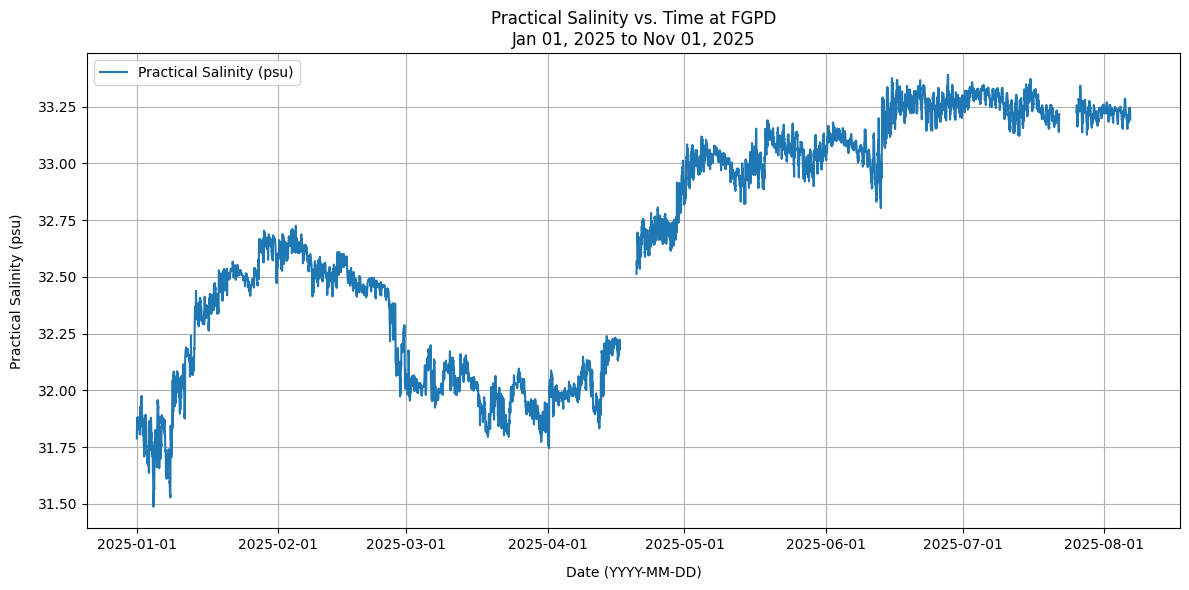

In [23]:
if resample: # Since we use the resample parameter for long time series, the program will use this code to plot.

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the data frame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Below we set our title and labels using formatted strings - 'f strings'. 
    # This lets us insert variable values (like name, location_code, or date) 
    # directly into the text using {braces}.

    # Set plot title
    plt.title(f"{name} vs. Time at {location_code}" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
    # STUDENT VERSION: plt.title(f"YOUR TITLE HERE" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
            f"\n{start_time.strftime('%b %d, %Y')} to {end_time.strftime('%b %d, %Y')}")
    
    # Set axis labels
    plt.xlabel("Date (YYYY-MM-DD)", labelpad=10)
    plt.ylabel(f"{name} ({unit})", labelpad=10)

    # Format x-axis dates according to ISO format: YYYY-MM-DD
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    
    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # This last line generates your plot
    plt.show()

## 7. Challenges

Now that you have walked through this plotting tutorial, go back and modify the code to change some parameters to plot something different. For example:

- Plot a different time period (section 2 - try January through August 2021)

- Plot a different instrument, for example: "locationCode": "FGPD.O2" instead of "FGPD" and "deviceCategoryCode": "OXYSENSOR" instead of "CTD"  (section 2)

### 7.1 Troubleshooting

- Check spelling and accuracy of your replaced parameters. Also check capitalization and case sensitivity (match what you found in the original code)

- Look for any missing brackets or quote marks, commas

- Check your plots to make sure you plotted what you intended to plot. Also check your plot legend, title, axes

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cd2cd01-70e8-41b6-af2d-f797c6675dbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>